In [171]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from gridworld.environment import WindyGridworld
from tensorflow import keras
from tqdm.notebook import tqdm
import pandas as pd
import copy


## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [172]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_large.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.array([0,1,2,3,4]),100)
X_test = np.array([[1,1], [3,3],[0,-2]])

# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)


num_concepts = len(means)
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=None, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(7923,)
(7923,)
(7923,)
(7923,)
(7923,)
(5, 2)
(500, 2)


# Data pre-processing

In [173]:
A = env.A

def generate_default_dataset(window_size):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Learning $\pi_b$

### $\pi_b(a|\hat{s})$
Here $\hat{s}$ is the average state over a window of previous states of length $W_s$.
For use in vanilla IS.

In [174]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b.save("saved_models/pi_b")
# pi_b = keras.models.load_model("saved_models/pi_b") 

(2149370, 2)
(2149370, 4)
Epoch 1/10
53735/53735 [==============================] - 66s 1ms/step - loss: 1.1446 - categorical_accuracy: 0.4838 - val_loss: 1.1440 - val_categorical_accuracy: 0.4858
Epoch 2/10
53735/53735 [==============================] - 58s 1ms/step - loss: 1.1427 - categorical_accuracy: 0.4852 - val_loss: 1.1436 - val_categorical_accuracy: 0.4868
Epoch 3/10
53735/53735 [==============================] - 60s 1ms/step - loss: 1.1424 - categorical_accuracy: 0.4853 - val_loss: 1.1431 - val_categorical_accuracy: 0.4878
Epoch 4/10
53735/53735 [==============================] - 60s 1ms/step - loss: 1.1422 - categorical_accuracy: 0.4859 - val_loss: 1.1430 - val_categorical_accuracy: 0.4865
Epoch 5/10
53735/53735 [==============================] - 60s 1ms/step - loss: 1.1420 - categorical_accuracy: 0.4860 - val_loss: 1.1427 - val_categorical_accuracy: 0.4864
Epoch 6/10
53735/53735 [==============================] - 61s 1ms/step - loss: 1.1419 - categorical_accuracy: 0.4861 - 

In [83]:
pi_b.predict(np.array([-3,2]).reshape(1,2))[0]

array([0.20653915, 0.21568644, 0.508844  , 0.06893032], dtype=float32)

-3.0


/Users/jackteversham/Documents/Imperial/Thesis/concepts-ope/gridworld/environment.py:142: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions.append(np.array(action_history))


397
2.0
160


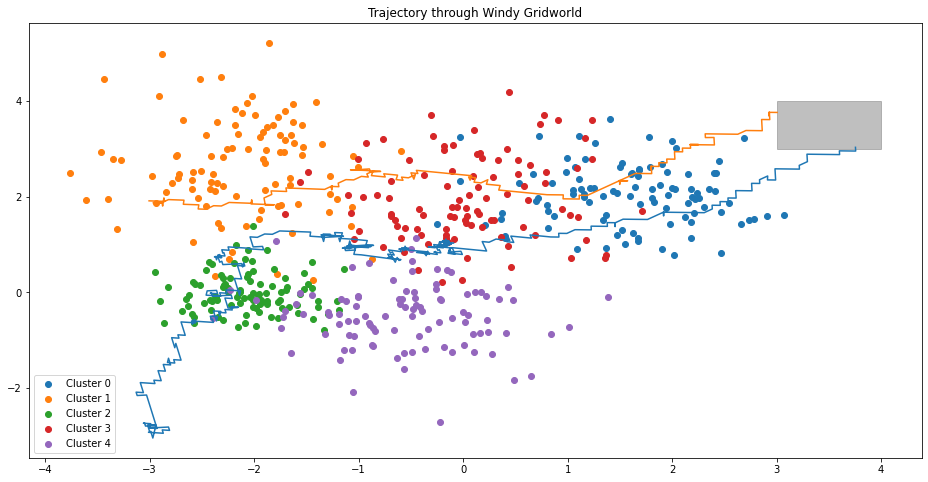

In [84]:
fig, ax2 = plt.subplots(figsize=(16,8))

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,2,2):
    print(y)
    history = env.play(True, [], [], [], [], [], s = np.array([-3, y]))
    print(len(history))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

### $\pi_b(a|c=f(\hat{s}))$
For use in concept IS. Can also just use default policy used to generate data, inherent to the dataset $\mathcal{D}$, but would like to try both.

In [175]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
#conver to concepts here
concept_model = keras.models.load_model("saved_models/c|s")
Xc_train = concept_model.predict(X_train)
Xc_test = concept_model.predict(X_test)
pi_b_c = PolicyModel(input_size=Xc_train[0].shape, num_actions=4).build()
history = pi_b_c.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b_c.save("saved_models/pi_b_c")
#                                                                                                                                                                       pi_b_c = keras.models.load_model("saved_models/pi_b_c") 

Epoch 1/10
53735/53735 [==============================] - 65s 1ms/step - loss: 1.1524 - categorical_accuracy: 0.4742 - val_loss: 1.1502 - val_categorical_accuracy: 0.4757
Epoch 2/10
53735/53735 [==============================] - 66s 1ms/step - loss: 1.1505 - categorical_accuracy: 0.4761 - val_loss: 1.1499 - val_categorical_accuracy: 0.4751
Epoch 3/10
53735/53735 [==============================] - 64s 1ms/step - loss: 1.1499 - categorical_accuracy: 0.4765 - val_loss: 1.1499 - val_categorical_accuracy: 0.4773
Epoch 4/10
53735/53735 [==============================] - 63s 1ms/step - loss: 1.1495 - categorical_accuracy: 0.4771 - val_loss: 1.1492 - val_categorical_accuracy: 0.4776
Epoch 5/10
53735/53735 [==============================] - 61s 1ms/step - loss: 1.1493 - categorical_accuracy: 0.4775 - val_loss: 1.1491 - val_categorical_accuracy: 0.4778
Epoch 6/10
53735/53735 [==============================] - 61s 1ms/step - loss: 1.1491 - categorical_accuracy: 0.4777 - val_loss: 1.1496 - val_cat

In [267]:
input = [0, 0, 0, 0, 1]
input2 = concept_model.predict(np.array([0,2]).reshape(1,2))[0]
print(input)
print(input2)
print("concept: ", np.argmax(input2))
print(pi_b_c.predict(np.array(input).reshape(1,5))) #action probability distribution for a given concept
print(pi_b_c.predict(np.array(input2).reshape(1,5)))
# np.mean(pi_b_c.predict(Xc_test), axis=0)

[0, 0, 0, 0, 1]
[7.977218e-11 8.685664e-09 2.940854e-17 1.000000e+00 4.782357e-23]
concept:  3
[[0.55403537 0.07854813 0.28875828 0.07865817]]
[[0.30413994 0.17288452 0.45090157 0.07207396]]


In [268]:
d0 = np.array([0.4281377,  0.07250687, 0.42525867, 0.07409684])
d1 = np.array([0.20833136, 0.20546675, 0.51395243, 0.07224946])
d2 = np.array([0.438365 ,  0.11837474, 0.3666041 , 0.07665614])
d3 = np.array([0.30413994, 0.17288451, 0.4509015,  0.07207396])
d4 = np.array([0.55403537, 0.07854813, 0.28875828, 0.07865817])

print((d0+d1+d2+d3+d4)/5)


[0.38660187 0.1295562  0.409095   0.07474691]


In [176]:
concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", knn, means, pi_b_c, None, concept_model)

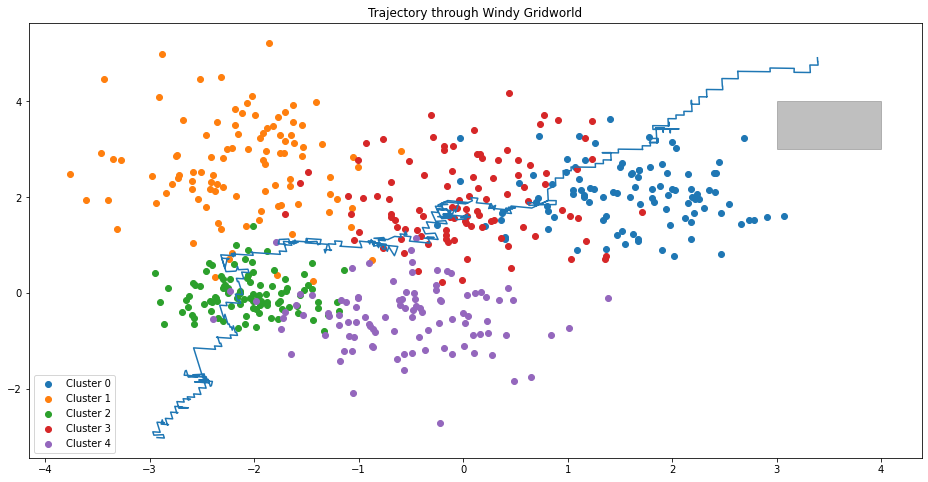

In [89]:
history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Evaluation Policies $\pi_e(a|c=f(\cdot))$ and $\pi_e(a|s)$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|s)$

In [90]:
def eval_policy_a_s(s, A, trajectory=None, concept_model=None, window_states=None):
    s = s.reshape((1,2))
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.13, 0.35, 0.17] #a new distribution of actions, different from behavioural policy

    return A[np.random.choice(indices, 1, p=p)[0]], p

In [ ]:
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, eval_policy_a_s)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s))$
Note here that the state is at one time step and not average over a window of $W_s$ previous states.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states=None):
    s = s.reshape((1,2))
    c = np.argmax(concept_model.predict(s)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p

concept_model = keras.models.load_model("saved_models/c|s") #How can I incorporate future values here? Not possible I dont think. rethink the concept learning using previous values
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(\hat{s}))$
Note here that the state $\hat{s}$ is averaged over a window of $W_s$ previous states.

/Users/jackteversham/Documents/Imperial/Thesis/concepts-ope/gridworld/environment.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions.append(np.array(action_history))


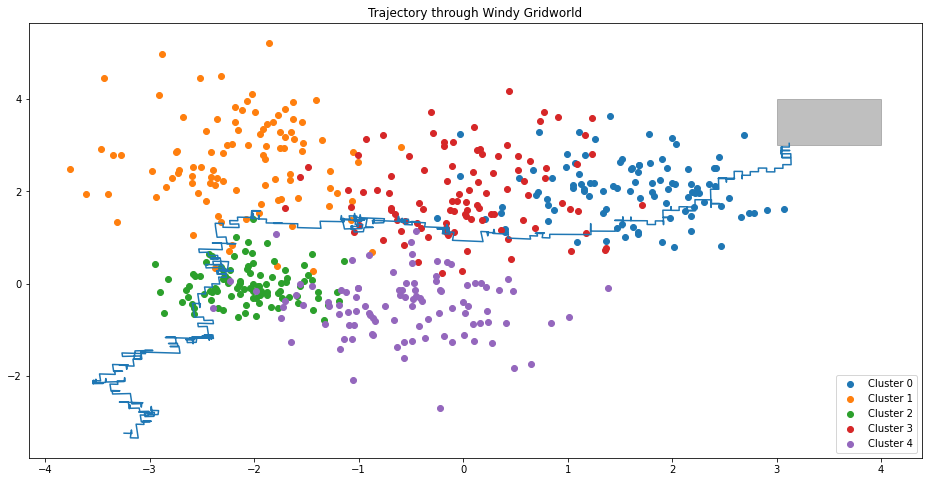

In [10]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    if len(trajectory)==0:
        return s
    s_hat = window_states(trajectory, W_s=10)
    s_hat = s_hat.reshape((1,2))

    c = np.argmax(concept_model.predict(s_hat)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s, s'))$
Note here that the state $s'$ is the previous state.

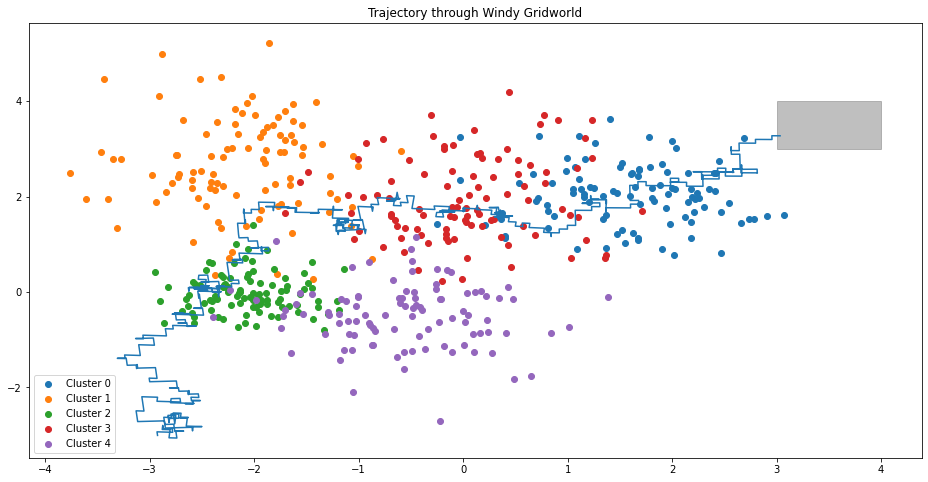

In [11]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    s_input = np.concatenate([s,s])
    if len(trajectory) > 1:
        s_prime = trajectory[len(trajectory)-1]
        s_input = np.concatenate([s,s_prime])

    s_input = s_input.reshape((1,4))    

    c = np.argmax(concept_model.predict(s_input)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s-s_dash")
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Importance Sampling
We need to compute the value and variance of:
* $V_{IS}$
* $V_{PDIS}$
* $V_{IS}^{concept}$
* $V_{PDIS}^{concept}$

Intuitively, a conceptual region covers more area in the state space and hence there should be more overlap between the behavioural and evaluation policies, and therefore less variance. Note that certain concepts may result in less variance while others may not. We will then need to optimise over the concepts to find the set which reduce the variance the most.

The below formulation is of per-decision importance sampling (PDIS). We need to construct the formulation of vanilla IS too. 

$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|s_t)}{\pi_b(a_t|s_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

In [248]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))
unique_concept_combinations_visited

concepts_to_trajectories_mapping = {}
for combination in unique_concepts:
    concepts_to_trajectories_mapping[tuple(combination)] = []


for idx, concept_list in enumerate(unique_concepts):
    concepts_to_trajectories_mapping[tuple(concept_list)].append(idx)

print(concepts_to_trajectories_mapping.keys())
len(concepts_to_trajectories_mapping[(0,2,3)]) #try (0,1,3) (good) and (0,4) (bad)

Number of unique concept combinations visited 8
dict_keys([(0, 3, 4), (0, 1, 3), (0, 1, 2, 3, 4), (0, 2, 3, 4), (0, 4), (0, 2, 3), (0, 1, 2, 3), (0, 1, 3, 4)])


319

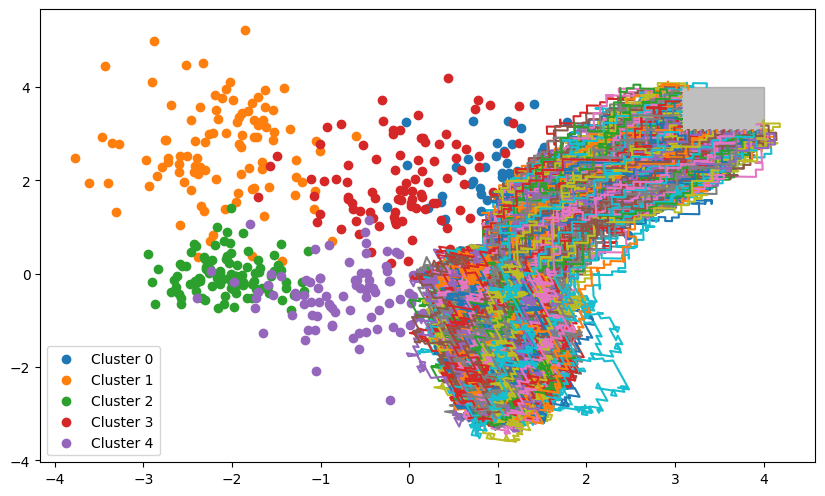

In [285]:
def plot_trajectories(trajectories, means, clusters):
        fig, ax = plt.subplots(figsize=(10,6), dpi=100)
        for history in trajectories:
            plt.plot(history[:, 0], history[:, 1])
    
        rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
        ax.add_patch(rect)
        for i in range(len(means)):
            start = i*100
            end = (i+1)*100
            plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

        plt.legend()
        plt.show()
trajectory_subset = trajectories[concepts_to_trajectories_mapping[(0,4)]]
plot_trajectories(trajectory_subset, means, clusters)
# print(len(trajectory_subset))

In [239]:

def pre_process(trajectories_original, actions_original, concept_model=None, pi_b=None,  pi_b_c=None, concept_mapping=None, concept_path=None):
    behaviour_distributions = []
    evaluation_distributions = []
    action_indicies = []
    trajectories = copy.deepcopy(trajectories_original)
    actions = copy.deepcopy(actions_original)


    if concept_mapping:
        trajectories = trajectories[concept_mapping[concept_path]] #selects subset of trajectories which travelled through a certain path of concepts
        actions = actions[concept_mapping[concept_path]]
        

    print("Pre-processing data....")
    for idx in range(len(trajectories)):
        completed_actions = actions[idx]
        trajectory = trajectories[idx]
        action_indicies.append(actions_to_action_indexes(completed_actions))

        if concept_model is not None:
            concepts = predict_concepts_from_states(trajectory, concept_model)
            behaviour_distributions.append(predict_actions_from_concepts(concepts, pi_b_c))
        else:
            behaviour_distributions.append(predict_actions_from_states(trajectory, pi_b))
    
    evaluation_distributions = copy.deepcopy(behaviour_distributions)
    print("Finished.")
    return behaviour_distributions, evaluation_distributions, action_indicies


def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    return np.array([np.where(np.all((A == a), axis=1))[0][0] for a in actions])

def predict_concepts_from_states(trajectory, concept_model):
    return np.array(concept_model.predict(trajectory))

def predict_actions_from_states(trajectory, pi_b):
    return np.array(pi_b.predict(trajectory)) 
    # self.evaluation_distributions = np.copy(self.behaviour_distributions)

def predict_actions_from_concepts(concepts, pi_b_c):
    return np.array(pi_b_c.predict(concepts))


class Estimator():

    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space

    def __init__(self, behaviour_distributions, evaluation_distributions, action_indicies, *args, **kwargs):
        self.behaviour_distributions = copy.deepcopy(behaviour_distributions)
        self.evaluation_distributions = copy.deepcopy(evaluation_distributions)
        self.action_indicies = copy.deepcopy(action_indicies)
        self.args = args
        self.kwargs = kwargs

    def IS():
        pass

    def PDIS(self, D, eval_policy):   
        value_estimate = 0
        on_policy_value = 0
        total_likelihood_ratios=0
        non_unit_likelihood_ratios=0

        for t in (range(D)):
            behaviour_dist = self.behaviour_distributions[t]
            T = len(behaviour_dist) #trajectory length
            evaluation_dist = self.evaluation_distributions[t]
            action_idxs = self.action_indicies[t]

            product, count =  self.rho(action_idxs, behaviour_dist, evaluation_dist, eval_policy)
            sum = self.g(T)
            value_estimate += sum  * product
            on_policy_value += sum
            non_unit_likelihood_ratios+= count
            total_likelihood_ratios += T

        return value_estimate/D, (non_unit_likelihood_ratios/total_likelihood_ratios)*100, on_policy_value/D

    def rho(self, actions_idx, behaviour_dist, evaluation_dist, eval_policy):
        product = 1
        count = 0

        r,_ = behaviour_dist.shape
        behaviour_probabilities = behaviour_dist[np.arange(r), actions_idx]
        evaluation_dist_copy = copy.deepcopy(evaluation_dist)
        
        for j in range(len(evaluation_dist)):
            epsilon = 0.2
            dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
            if dist_index == 1:
                replacement_distribution = eval_policy 
                evaluation_dist_copy[j] = replacement_distribution

        r,_ = evaluation_dist_copy.shape
        evaluation_probabilities = evaluation_dist_copy[np.arange(r), actions_idx]

        ratios = np.array(evaluation_probabilities/behaviour_probabilities)
        product = np.prod(ratios)
        count = len(np.where(ratios<0.4)[0])
        
        return product, count

    def g(self, T, gamma=1):
        r_t = -1
        return T*r_t

In [290]:
behaviour_distributions, evaluation_distributions, action_indicies = pre_process(
    trajectories,
    actions,
    None,
    pi_b,
    None,
    concept_mapping=concepts_to_trajectories_mapping,
    concept_path=(0,1,2,3)
)
behaviour_distributions_c, evaluation_distributions_c, action_indicies_c = pre_process(
    trajectories,
    actions,
    concept_model,
    pi_b,
    pi_b_c,
    concept_mapping=concepts_to_trajectories_mapping,
    concept_path=(0,1,2,3))

print("Dataset size: ",len(behaviour_distributions))

Pre-processing data....
Finished.
Pre-processing data....
Finished.
Dataset size:  983


In [291]:
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    # print(s)
    return data[s<m]

estimator = Estimator(behaviour_distributions=behaviour_distributions, evaluation_distributions=evaluation_distributions, action_indicies=action_indicies)
concept_estimator = Estimator(behaviour_distributions=behaviour_distributions_c, evaluation_distributions=evaluation_distributions_c, action_indicies=action_indicies_c)


dataset_sizes = [100, 300, 500, 700, 900]
# dataset_sizes = [25,50,75,100]
num_trials = 10
data = {}
data_no_outliers = {}

for D in dataset_sizes:
    values1, values2, ess_values1, ess_values2 = [], [], [], []
    for i in tqdm(range(num_trials)): 
        eval_policy =[0.409095, 0.1295562, 0.38660187, 0.07474691]#[0.38660187 0.1295562  0.409095   0.07474691]
        estimate, small_weights, on_policy_value = estimator.PDIS(D, eval_policy=eval_policy)
        estimate_concepts, small_weights_concepts, on_policy_value_concepts = concept_estimator.PDIS(D, eval_policy=eval_policy)
        values1.append(estimate)
        values2.append(estimate_concepts)
        ess_values1.append(small_weights)
        ess_values2.append(small_weights_concepts)
    values1 = np.array(values1)
    values2 = np.array(values2)
    data[f"{D}_vanilla"] = values1
    data[f"{D}_concepts"] = values2
    data_no_outliers[f"{D}_vanilla"] = reject_outliers(values1)
    data_no_outliers[f"{D}_concepts"] = reject_outliers(values2)
    print(f"Mean weights smaller than 0.8: {np.array(ess_values1).mean()}%")
    print(f"Mean weights smaller than 0.8: {np.array(ess_values2).mean()}%")
    print("On policy: ",on_policy_value)
    print("On policy onver concepts: ", on_policy_value_concepts)



Mean weights smaller than 0.8: 0.0%
Mean weights smaller than 0.8: 0.0%
On policy:  -365.92
On policy onver concepts:  -365.92


KeyboardInterrupt: 

In [275]:
# data = {"vanilla":values1,"concepts":values2, "vanilla_no_outliers":reject_outliers(values1),"concepts_no_outliers":reject_outliers(values2)}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
df_no_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data_no_outliers.items() ]))

print("With outliers")
print(df.describe())
print("Without outliers")
print(df_no_outliers.describe())


With outliers
       100_vanilla  100_concepts  300_vanilla  300_concepts  500_vanilla  \
count    10.000000     10.000000    10.000000     10.000000    10.000000   
mean  -1368.777485   -893.718202 -2893.550894   -716.509458 -1938.013916   
std     674.274686    301.127925  2419.861250    231.792465   538.781889   
min   -2644.618292  -1404.026085 -9148.316731  -1343.629642 -2676.826095   
25%   -1559.655834  -1065.471839 -2241.220606   -706.509742 -2433.652379   
50%   -1255.663072   -833.320341 -2079.739294   -662.277618 -1763.929445   
75%    -887.565677   -650.690156 -1782.278823   -621.797215 -1544.922780   
max    -646.734128   -557.894091 -1278.865629   -522.298728 -1190.286651   

       500_concepts  700_vanilla  700_concepts  900_vanilla  900_concepts  
count     10.000000    10.000000     10.000000    10.000000     10.000000  
mean    -903.581938 -3238.945876  -1023.286390 -1988.547774   -724.449681  
std      274.424536  2500.471917    986.910472   733.985752    129.289879

In [276]:
# df.to_parquet("parquets/ope_estimates_c_in_all_bad_policy")
# df_no_outliers.to_parquet("parquets/ope_estimates_c_in_all_no_outliers_bad_policy")

Some questions
1. Evaluate over full dataset? or sample different sized datasets from D?
2. The value of some estimates seems pretty low, is this normal?
3. Trajecotries are pretty long, is this an issue?
4. Choosing the evaluation policy - increase epslion for example? 

Considerations:

- changing policy to epsilon greedy on taking argmax of distribution. Or do we just sample action according to distribution (can't just be this)?
- Omitting likelihood ratios is equivalent to setting them to 1
- Over different simulations, the distribution over states should vary more than the distrbiution over concepts, hence higher variance